In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
import string
import datetime
from matplotlib import colors
from matplotlib.gridspec import GridSpec


(c1,c2,c3,c4)=('#1b9e77','#d95f02','#7570b3','#e7298a')

In [3]:
met_dict = pickle.load(open('met_dict.p','rb'))
df = pickle.load(open('night_df.p','rb'))
df.shape

(77939, 29)

# Make the big dataframe

In [4]:
df_cloudy_low = df[df['Low cloudiness']>9]
df_clear_total = df[df['Total cloudiness']<1]
df_clear_low = df[df['Low cloudiness']<1]
df_cloudy_high = df_clear_low[df_clear_low['Total cloudiness']>8]

In [5]:
def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])
    return subax


def plot_wind_hist(ax,df,lower_thresh,higher_thresh,color,label):
    df_calm = df[(df['Wind speed']<higher_thresh) & (df['Wind speed']>lower_thresh)]
    p,x = np.histogram(df_calm['diff'],bins=bins,density=True)
    
    ax.step(x[:-1]+(bw/2),p,alpha=1,label=label,color=color)
    
#     ax.bar(x[:-1]+(bw/2),p,alpha=0.1,width=bw,color=color)
    
    mean_diff = np.nanmean(df_calm['diff'])
#     ax.axvline(mean_diff,color=color,ls='--')
    
    return(mean_diff)


def plot_wind_line(ax,df,color,label,offset,var):
    
    centres = np.arange(0,19,1)
    w=0.5
    
    means = []
    stds = []
    for centre in centres:
        df_bin = df[(df[var]<centre+w) & (df[var]>centre-w)]
        means.append(np.nanmean(df_bin['diff']))
        stds.append(np.nanstd(df_bin['diff']))
        
    means = np.array(means)
    stds = np.array(stds)

    ax.plot(centres,means,color=color,label=label,zorder=10,marker='o',markersize=2)
    ax.plot(centres,means+stds,color=color,alpha=0.2,ls='-',zorder=5)
    ax.plot(centres,means-stds,color=color,alpha=0.2,ls='-',zorder=5)
    ax.fill_between(centres,
                    means+stds,
                    means-stds,
                    color=color,alpha=0.1)


    lr = linregress(centres,means)
    x = np.arange(w,19,0.01)
    y = lr[0]*x + lr[1]

    if label == 'High Cloud':
        print(x[np.argmin(np.abs(y))])
    
#     print(lr)

    return means
    
def make_stds(ax):

    bw=1

    bin_edges = np.arange(-0.5,19.5,bw)

    bin_ticks = [f'{bin_edges[i]}-{bin_edges[i+1]}' for i in range(len(bin_edges)-1)]

    def get_stds(df):

        bin_stds = []

        for i in range(len(bin_edges)-1):
            bin_start = bin_edges[i]
            bin_end = bin_edges[i+1]

            data_in_bin = df[(df['Wind speed']>bin_start)]
            data_in_bin = data_in_bin[data_in_bin['Wind speed']<bin_end]
            bin_std = np.nanstd(data_in_bin[diff])
            bin_stds.append(bin_std)

        return bin_stds

    h = get_stds(df_cloudy_high)
    l = get_stds(df_cloudy_low)
    c = get_stds(df_clear_total)

    bar_width = 0.2
    for i,offset,c,label in zip([c,h,l],
                          [-bar_width,0,bar_width],
                          [c2,c1,c3],
                          ['Clear Sky','High Cloud','Low Cloud']):

#         ax.bar(bin_edges[:-1]+(bw/2)+offset,i,width=bar_width)
        
        ax.plot(bin_edges[:-1]+(bw/2)+offset,i,color=c,label=label,marker='o',markersize=2)
        
        ax.set_xticks(np.arange(0,19,3),labels=np.arange(0,19,3))
        

def density(df,ax,xbins,ybins,caption,var):
    
    x = np.arange(0,30,1)

    density, _, _ = np.histogram2d(df[diff],df[var],[ybins,xbins])
    
#     ax.scatter(df['Wind speed'],df['diff'],alpha=0.1,color='grey')
    imsh = ax.imshow(density,cmap='Greys',norm=colors.LogNorm(vmin=1,vmax=10**3),
                     extent=[xbins[0],xbins[-1],ybins[-1],ybins[0]],
                    aspect='auto')
    
    ax.annotate(caption,ha='center',va='top',xy=(0.5,0.94),fontsize='x-large',xycoords='axes fraction')
    lr = linregress(df[var],df[diff])
    y = x*lr[0] + lr[1]
    ax.plot(x,y,color='r',ls='--')
    ax.annotate(f'r = {np.round(lr[2],2)}\nslope = {np.round(lr[0],2)}',ha='right',va='bottom',xy=(0.97,0.03),fontsize='x-large',xycoords='axes fraction')
    ax.set_xticks(np.arange(0,19,3))
    ax.set_xlim(-0.5,19)
#     ax.axhline(0,color='r',ls='-',lw=0.5)
    ax.set_ylim(ybins[0],ybins[-1])
    ax.set_yticks(np.arange(-7.5,7.6,2.5))
    ax.axhline(0,color='r')
    
    return imsh

15.810000000000013


/tmp/ipykernel_4313/1905587132.py:81: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.05,hspace=0)


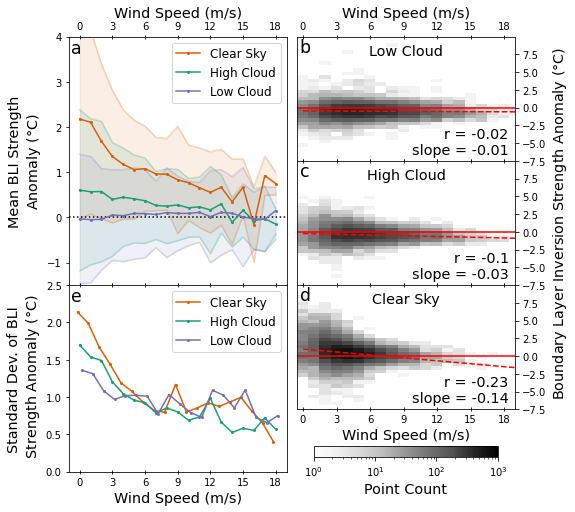

In [6]:
var = 'Wind speed'
diff = 'diff_anom'

plt.rcParams['legend.title_fontsize'] = 'large'

fig = plt.figure(constrained_layout=True,figsize=(8,8))

x=2
gs = GridSpec(7, 2, figure=fig)

ax1 = fig.add_subplot(gs[0:4,0])
ax2 = fig.add_subplot(gs[0:2,1])
ax3 = fig.add_subplot(gs[2:4,1])
ax4 = fig.add_subplot(gs[4:6,1])
ax5 = fig.add_subplot(gs[4:7,0])

### AX1
offset=0.2

c = plot_wind_line(ax1,df_clear_total,c2,'Clear Sky',offset,var)
h = plot_wind_line(ax1,df_cloudy_high,c1,'High Cloud',0,var)
l = plot_wind_line(ax1,df_cloudy_low,c3,'Low Cloud',-offset,var)

ax1.legend(fontsize='large')
ax1.axhline(0,color='k',ls=':')
ax1.set_ylim(-1.5,4)
ax1.set_xlabel('Wind Speed (m/s)',fontsize='x-large')
ax1.set_xticks(np.arange(0,19,3))
ax1.set_ylabel('Mean BLI Strength\nAnomaly ($\degree$C)',fontsize='x-large')
ax1.xaxis.set_label_position('top')
ax1.xaxis.tick_top()
ax1.set_xlim(-1,19)

############# HEAT MAPS
    
xbins,ybins = np.arange(-0.5,20.5,1),np.arange(-7.5,10.1,0.5)

ishow=density(df_cloudy_low,ax2,xbins,ybins,'Low Cloud',var)
density(df_cloudy_high,ax3,xbins,ybins,'High Cloud',var)
density(df_clear_total,ax4,xbins,ybins,'Clear Sky',var)

for ax in [ax2,ax4]:
    ax.set_xlabel('Wind Speed (m/s)',fontsize='x-large')

ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')

ax3.set_xticklabels([])


for ax in [ax2,ax3,ax4]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')


############ AX5 STD

make_stds(ax5)
ax5.set_xlabel('Wind Speed (m/s)',fontsize='x-large')
ax5.set_ylim(0,2.5)
ax5.set_ylabel('Standard Dev. of BLI\n Strength Anomaly ($\degree$C)',fontsize='x-large')
ax5.set_xlim(-1,19)
ax5.legend(fontsize='large')

####################

for ax,letter in zip([ax1,ax2,ax3,ax4,ax5],string.ascii_letters):
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="x", direction="inout")
    ax.annotate(f'{letter}',
             xycoords='axes fraction',
             xy=(0.01,0.99),
             va='top',
             fontsize='xx-large')

ax3.set_ylabel('Boundary Layer Inversion Strength Anomaly ($\degree$C)',fontsize='x-large')




plt.subplots_adjust(wspace=0.05,hspace=0)


position=fig.add_axes([0.55,0.15,0.32,0.02])  ## the parameters are the specified position you set 
cb = plt.colorbar(ishow,cax=position,orientation='horizontal')
cb.set_label('Point Count',fontsize='x-large')

plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/Inversion/main_figs/wind.png',dpi=400,bbox_inches='tight')

plt.show()

Clear Sky
Average BLI:
1.3098501303214596
Mean Wind Speed:
4.104691572545613

Low Cloud
Average BLI:
0.05419265419265419
Mean Wind Speed:
5.836867636867637

High Cloud
Average BLI:
0.37752717391304347
Mean Wind Speed:
5.502264492753623

All Regimes
Average BLI:
0.6624458825137857
Mean Wind Speed:
5.025816889212961

5.025816889212961


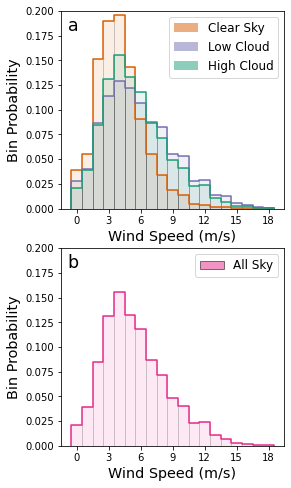

In [70]:
ps = []

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(4,8))

for df_, name, color in zip([df_clear_total, df_cloudy_low, df_cloudy_high],
                        ['Clear Sky', 'Low Cloud', 'High Cloud'],
                         [c2,c3,c1],
                            ):
    print(name)
    print('Average BLI:')
    print(np.nanmean(df_['diff']))
    print('Mean Wind Speed:')
    print(np.nanmean(df_['Wind speed']))
#     print('Median Wind Speed:')
#     print(np.nanmedian(df_['Wind speed']))
    print()
    p, x = np.histogram(df_['Wind speed'],density=True,bins=np.arange(-0.5,19.5,1))
    ax1.bar(x[:-1]+0.5,p,color=color,width=1,alpha=0.1,edgecolor='k')
    ax1.bar([0],[0],color=color,width=1,alpha=0.5,label=name)
    ax1.step([-0.51]+list(x),[0]+list(p)+[0],color=color,where='post')
    
#     ax1.axvline(np.nanmean(df_['Wind speed']),color=color,ls='--',label=name)
    
    ps.append(p)
    
ax1.legend(fontsize='large')
    
df_clouds = pd.concat([df_clear_total, df_cloudy_low, df_cloudy_high],axis=0)
    
print('All Regimes')
print('Average BLI:')
print(np.nanmean(df_clouds['diff']))
print('Mean Wind Speed:')
print(np.nanmean(df_clouds['Wind speed']))
# print('Median Wind Speed:')
# print(np.nanmedian(df_clouds['Wind speed']))
print()
    
# plt.bar(x[:-1]+0.5,histogram,width=1,facecolor='none',hatch='//')

p_all, x = np.histogram(df_clouds['Wind speed'], density=True, bins=np.arange(-0.5,19.5,1))
ax2.bar(x[:-1]+0.5,p,color=c4,width=1,alpha=0.1,edgecolor='k')
ax2.bar([0],[0],color=c4,width=1,alpha=0.5,edgecolor='k',label='All Sky')
ax2.step([-0.51]+list(x),[0]+list(p)+[0],color=c4,where='post')
print(np.nanmean(df_clouds['Wind speed']))
ax2.legend(fontsize='large')

for ax in [ax1,ax2]:
    ax.set_ylabel('Bin Probability',fontsize='x-large')
    ax.set_xlabel('Wind Speed (m/s)',fontsize='x-large')
    
for ax,letter in zip([ax1,ax2],string.ascii_letters):

    ax.set_xticks(np.arange(0,19,3))
    ax.annotate(f'{letter}',
             xycoords='axes fraction',
             xy=(0.03,0.97),
             va='top',
             fontsize='xx-large')
    
    ax.set_ylim(0,0.2)
    

plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/Inversion/main_figs/wind_hists.png',dpi=400,bbox_inches='tight')


In [ ]:
plt.plot()

Why is the corrected average lower when 

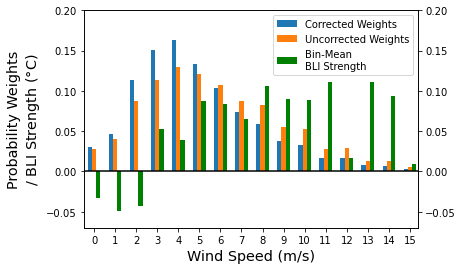

In [69]:
fig, ax1 = plt.subplots(1,1)

bw = 0.2

ax1.bar(np.arange(len(l))-bw,p_all,label='Corrected Weights',width=bw)
ax1.bar(np.arange(len(l)),ps[1],label='Uncorrected Weights',width=bw)
ax1.set_xlabel('Wind Speed (m/s)',fontsize='x-large')
ax1.set_xticks(np.arange(0,20))
ax1.set_xlim(-0.5,15.4)
ax1.set_ylabel('Probability Weights\n/ BLI Strength ($\degree$C)',fontsize='x-large')

ax2=ax1.twinx()
ax2.set_ylim(-0.07,0.2)

ax1.set_ylim(-0.07,0.2)
ax1.bar(np.arange(len(l))+bw,l,color='g',alpha=1,width=bw,label='Bin-Mean\nBLI Strength')
ax1.axhline(0,color='k')

ax1.legend()


plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/Inversion/supp_figs/wind_weights.png',dpi=400,bbox_inches='tight')

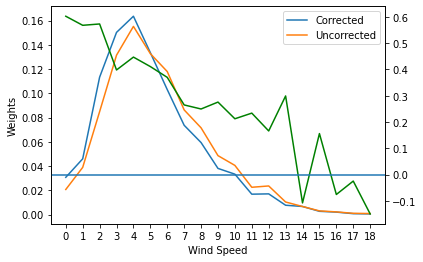

In [158]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(p_all,label='Corrected')
ax1.plot(ps[2],label='Uncorrected')
ax1.set_xlabel('Wind Speed')
ax1.legend()
ax1.set_xticks(np.arange(0,20))
ax1.set_ylabel('Weights')

ax2=ax1.twinx()
ax2.plot(h,color='g')
ax2.axhline(0)

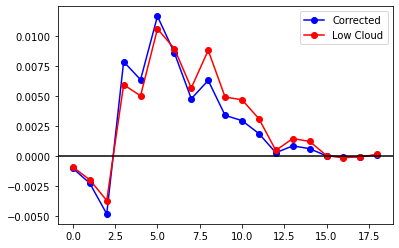

In [152]:
plt.plot(np.multiply(p_all,l),label='Corrected',color='b',marker='o')
plt.plot(np.multiply(ps[1],l),label='Low Cloud',color='r',marker='o')
plt.axhline(0,color='k')
plt.legend()

In [136]:
for BLI, p in zip([c,l,h],ps):
    
    x = np.average(BLI,weights=p)
    
    y = np.average(BLI,weights=p_all)
    
    print(np.nanmean(x),np.nanmean(y))

1.309704045614988 1.2176592241914328
0.05447859571220426 0.047608344518420095
0.37777979157227004 0.39614761263924936


LinregressResult(slope=-0.05055013434832252, intercept=1.458120720373314, rvalue=-0.8374804026287689, pvalue=0.07670282964111749, stderr=0.019043696892372182, intercept_stderr=0.21879541963982715)
17.259999999999675
LinregressResult(slope=-0.03327526211462718, intercept=0.5743533729929235, rvalue=-0.9932024210011317, pvalue=0.0006720814902464626, stderr=0.0022515205907290684, intercept_stderr=0.025868002166826887)
LinregressResult(slope=-0.000223904591277653, intercept=0.05953447724445635, rvalue=-0.024712242494935546, pvalue=0.9685385984555182, stderr=0.005229468647300242, intercept_stderr=0.06008202050504545)


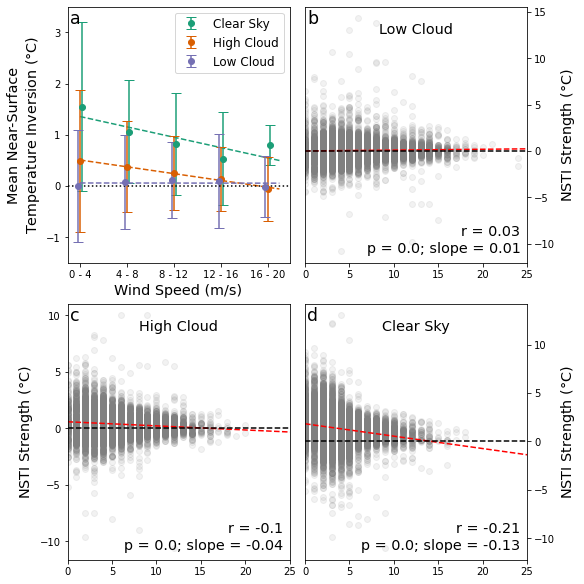

In [70]:
plt.rcParams['legend.title_fontsize'] = 'large'

fig = plt.figure(constrained_layout=True,figsize=(8,8))

x=2
gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])

### Ax1


w=2
centres = np.arange(w,18.1,2*w)
    
    
offset=0.2
plot_wind_line(ax1,df_clear_total,c1,'Clear Sky',offset)
plot_wind_line(ax1,df_cloudy_high,c2,'High Cloud',0)
plot_wind_line(ax1,df_cloudy_low,c3,'Low Cloud',-offset)

ax1.legend(fontsize='large')
ax1.axhline(0,color='k',ls=':')
ax1.set_ylim(-1.5,3.5)
ax1.set_xlabel('Wind Speed (m/s)',fontsize='x-large')
xticklabs = [f'{int(c-w)} - {int(c+w)}' for c in centres]
ax1.set_xticks(centres)
ax1.set_xticklabels(xticklabs)
ax1.set_ylabel('Mean Near-Surface\nTemperature Inversion ($\degree$C)',fontsize='x-large')

############# hexbins

def pd(df,ax,xbins,ybins,caption):
    
    x = np.arange(0,30,1)

#     density, _, _ = np.histogram2d(df['diff'],df['Wind speed'],[ybins,xbins])
    
    ax.scatter(df['Wind speed'],df['diff'],alpha=0.1,color='grey')
    
    ax.annotate(caption,ha='center',va='top',xy=(0.5,0.94),fontsize='x-large',xycoords='axes fraction')
    lr = linregress(df['Wind speed'],df['diff'])
    y = x*lr[0] + lr[1]
    ax.plot(x,y,color='r',ls='--')
    ax.annotate(f'r = {np.round(lr[2],2)}\np = {np.round(lr[3],2)}; slope = {np.round(lr[0],2)}',ha='right',va='bottom',xy=(0.97,0.03),fontsize='x-large',xycoords='axes fraction')
    ax.set_ylabel('NSTI Strength ($\degree$C)',fontsize='x-large')
    ax.set_xticks(np.arange(0,25.1,5))
    ax.set_xlim(0,25)
    ax.axhline(0,color='k',ls='--')
    
xbins,ybins = np.arange(0,20,0.5),np.arange(-5,5.1,0.5)

pd(df_cloudy_low,ax2,xbins,ybins,'Low Cloud')
pd(df_cloudy_high,ax3,xbins,ybins,'High Cloud')
pd(df_clear_total,ax4,xbins,ybins,'Clear Sky')

for ax in [ax2,ax4]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')

    

ax1.annotate(f'a',
             xycoords='axes fraction',
             xy=(0.01,0.99),
             va='top',
             fontsize='xx-large')

ax2.annotate(f'b',
             xycoords='axes fraction',
             xy=(0.01,0.99),
             va='top',
            fontsize='xx-large')

ax3.annotate(f'c',
             xycoords='axes fraction',
             xy=(0.01,0.99),
             va='top',
             fontsize='xx-large')

ax4.annotate(f'd',
             xycoords='axes fraction',
             xy=(0.01,0.99),
             va='top',
             fontsize='xx-large')

ax5.annotate(f'e',
             xycoords='axes fraction',
             xy=(0.01,0.99),
             va='top',
             fontsize='xx-large')

plt.show()


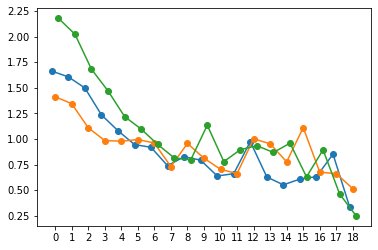

LinregressResult(slope=-0.05055013434832252, intercept=1.458120720373314, rvalue=-0.8374804026287689, pvalue=0.07670282964111749, stderr=0.019043696892372182, intercept_stderr=0.21879541963982715)
17.259999999999675
LinregressResult(slope=-0.03327526211462718, intercept=0.5743533729929235, rvalue=-0.9932024210011317, pvalue=0.0006720814902464626, stderr=0.0022515205907290684, intercept_stderr=0.025868002166826887)
LinregressResult(slope=-0.000223904591277653, intercept=0.05953447724445635, rvalue=-0.024712242494935546, pvalue=0.9685385984555182, stderr=0.005229468647300242, intercept_stderr=0.06008202050504545)


/home/robbie/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


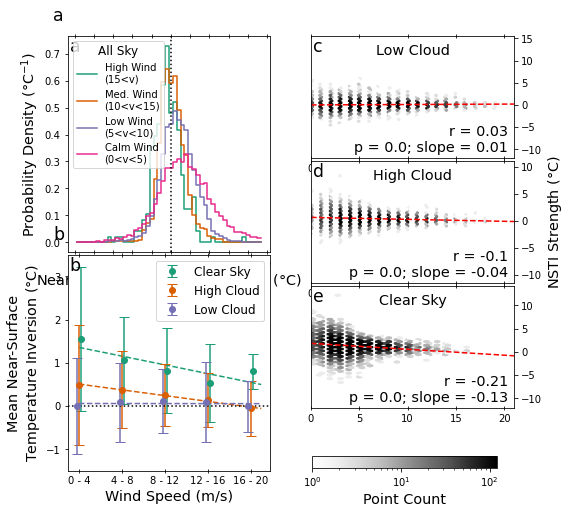

In [35]:
plt.rcParams['legend.title_fontsize'] = 'large'

fig = plt.figure(constrained_layout=True,figsize=(8,8))

x=2
gs = GridSpec(14*x, 2, figure=fig)

ax1 = fig.add_subplot(gs[:7*x,0])
ax2 = fig.add_subplot(gs[7*x:14*x,0])
ax3 = fig.add_subplot(gs[:4*x,1])
ax4 = fig.add_subplot(gs[4*x:8*x,1])
ax5 = fig.add_subplot(gs[8*x:12*x,1])

### Ax1

bw = 0.2
alpha=0.4
bins=np.arange(-5,5,bw)
    

h = plot_wind_hist(ax1,df,15,1000,c1,label='High Wind\n(15<v)')
m = plot_wind_hist(ax1,df,10,15,c2,label='Med. Wind\n(10<v<15)')
l = plot_wind_hist(ax1,df,5,10,c3,label='Low Wind\n(5<v<10)')
n = plot_wind_hist(ax1,df,0,5,c4,label='Calm Wind\n(0<v<5)')


ax1.axvline(0,color='k',ls=':')
ax1.set_ylabel('Probability Density ($\degree$C$^{-1}$)',fontsize='x-large')
ax1.set_xlabel('Near-Surface Inversion Strength ($\degree$C)',fontsize='x-large')
ax1.legend(loc='upper left',fontsize='medium',title='All Sky')

ax1.set_xticks(np.arange(-5,5.1,1))

# ### INSET to AX1

# rect = [0.68,0.67,0.3,0.3]
# axi = add_subplot_axes(ax1,rect)

# axi.bar(np.array([2.5,7.5,12.5,17.5]),[n,l,m,h],width=5,color=(c4,c3,c2,c1))
# axi.set_xticks([2.5,7.5,12.5,17.5])
# axi.set_xticklabels(['Calm','Low','Med','High'],fontsize='medium',rotation=90)
# axi.axhline(0,color='k',lw=0.5)
# axi.set_ylabel('Hist. Mean ($\degree$C)',labelpad=-1)
# axi.plot(np.array([2.5,7.5,12.5,17.5]),[n,l,m,h],color='k',marker='o',markersize=5)
# axi.set_yticks(np.arange(0,1.01,0.2))
# axi.set_yticklabels(np.arange(0,10.1,2).astype(np.int)/10,
#                     fontsize='medium')


########## AX2

w=2
centres = np.arange(w,18.1,2*w)

def plot_wind_line(ax,df,color,label,offset):
    means = []
    stds = []
    for centre in centres:
        df_bin = df[(df['Wind speed']<centre+w) & (df['Wind speed']>centre-w)]
        means.append(np.nanmean(df_bin['diff']))
        stds.append(np.nanstd(df_bin['diff']))
#     ax.scatter(centres,means,color=color)
    ax.errorbar(centres+offset,means,yerr=stds,color=color,label=label,ls='',capsize=5,marker='o',alpha=1)
    lr = linregress(centres,means)
    x = np.arange(w,19,0.01)
    y = lr[0]*x + lr[1]
    ax.plot(x,y,color=color,ls='--')
    
    if label == 'High Cloud':
        print(x[np.argmin(np.abs(y))])
    
    print(lr)
    
    
offset=0.2
plot_wind_line(ax2,df_clear_total,c1,'Clear Sky',offset)
plot_wind_line(ax2,df_cloudy_high,c2,'High Cloud',0)
plot_wind_line(ax2,df_cloudy_low,c3,'Low Cloud',-offset)

ax2.legend(fontsize='large')
ax2.axhline(0,color='k',ls=':')
ax2.set_ylim(-1.5,3.5)
ax2.set_xlabel('Wind Speed (m/s)',fontsize='x-large')
xticklabs = [f'{int(c-w)} - {int(c+w)}' for c in centres]
ax2.set_xticks(centres)
ax2.set_xticklabels(xticklabs)
ax2.set_ylabel('Mean Near-Surface\nTemperature Inversion ($\degree$C)',fontsize='x-large')

############# hexbins


x = np.arange(0,25,1)
v,h=90,30
# hex_area = 
cmap = 'Greys'
hb = ax3.hexbin(df_cloudy_low['Wind speed'],df_cloudy_low['diff'],cmap=cmap,gridsize=(v,h),vmin=1,vmax=120,bins='log')
ax3.annotate('Low Cloud',ha='center',va='top',xy=(0.5,0.94),fontsize='x-large',xycoords='axes fraction')
lr = linregress(df_cloudy_low['Wind speed'],df_cloudy_low['diff'])
y = x*lr[0] + lr[1]
ax3.plot(x,y,color='r',ls='--')
ax3.annotate(f'r = {np.round(lr[2],2)}\np = {np.round(lr[3],2)}; slope = {np.round(lr[0],2)}',ha='right',va='bottom',xy=(0.97,0.03),fontsize='x-large',xycoords='axes fraction')

ax4.hexbin(df_cloudy_high['Wind speed'],df_cloudy_high['diff'],cmap=cmap,gridsize=(v,h),vmin=1,vmax=120,bins='log')
ax4.annotate('High Cloud',ha='center',va='top',xy=(0.5,0.94),fontsize='x-large',xycoords='axes fraction')
lr = linregress(df_cloudy_high['Wind speed'],df_cloudy_high['diff'])
y = x*lr[0] + lr[1]
ax4.plot(x,y,color='r',ls='--')
ax4.annotate(f'r = {np.round(lr[2],2)}\np = {np.round(lr[3],2)}; slope = {np.round(lr[0],2)}',ha='right',va='bottom',xy=(0.97,0.03),fontsize='x-large',xycoords='axes fraction')

ax5.hexbin(df_clear_total['Wind speed'],df_clear_total['diff'],cmap=cmap,gridsize=(v,h),vmin=1,vmax=120,bins='log')
ax5.annotate('Clear Sky',ha='center',va='top',xy=(0.5,0.94),fontsize='x-large',xycoords='axes fraction')
lr = linregress(df_clear_total['Wind speed'],df_clear_total['diff'])
y = x*lr[0] + lr[1]
ax5.plot(x,y,color='r',ls='--')
ax5.annotate(f'r = {np.round(lr[2],2)}\np = {np.round(lr[3],2)}; slope = {np.round(lr[0],2)}',ha='right',va='bottom',xy=(0.97,0.03),fontsize='x-large',xycoords='axes fraction')



ax1.annotate(f'a',
             xycoords='axes fraction',
             xy=(-0.07,1.07),
            fontsize='xx-large')

ax2.annotate(f'b',
             xycoords='axes fraction',
             xy=(-0.07,1.07),
            fontsize='xx-large')

for ax in [ax3,ax4,ax5]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    ax.set_xticks(np.arange(0,21,5))
    ax.set_xlim(0,21)
#     ax.set_ylim(-12,9)
#     ax.set_yticks(np.arange(-10,7.6,2.5))
    
for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="x", direction="inout")
    

ax4.set_ylabel('NSTI Strength ($\degree$C)',fontsize='x-large')


ax1.annotate(f'a',
             xycoords='axes fraction',
xy=(0.01,0.99),
             va='top',            fontsize='xx-large')

ax2.annotate(f'b',
             xycoords='axes fraction',
             xy=(0.01,0.99),
             va='top',
            fontsize='xx-large')

ax3.annotate(f'c',
             xycoords='axes fraction',
xy=(0.01,0.99),
             va='top',            fontsize='xx-large')

ax4.annotate(f'd',
             xycoords='axes fraction',
xy=(0.01,0.99),
             va='top',            fontsize='xx-large')

ax5.annotate(f'e',
             xycoords='axes fraction',
xy=(0.01,0.99),
             va='top',            fontsize='xx-large')

position=fig.add_axes([0.55,0.13,0.32,0.02])  ## the parameters are the specified position you set 
cb = plt.colorbar(hb,cax=position,orientation='horizontal')
cb.set_label('Point Count',fontsize='x-large')

# plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/Inversion/F2.png',dpi=400,bbox_inches='tight')

plt.show()


In [6]:
np.nanmean(df_cloudy_low['Wind speed']), np.nanmean(df_cloudy_high['Wind speed']), np.nanmean(df_clear_total['Wind speed']) 

(5.825688724794093, 5.4902089384428, 4.1162737072692686)